#### 1. Imports

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)


Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.2.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

#### 2. Load the data

The Chest X-ray data we are using from [*Cell*](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) divides the data into train, val, and test files. There are only 16 files in the validation folder, and we would prefer to have a less extreme division between the training and the validation set. We will append the validation files and create a new split that resembes the standard 80:20 division instead.

In [ ]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

Run the following cell to see how many healthy/normal chest X-rays we have and how many pneumonia chest X-rays we have.

In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1071
Pneumonia images count in training set: 3114


In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'gs://kds-02487f1c1b92a852ac6198d30ff9dbc16d327b5fd344e76edf959e06/chest_xray/train/PNEUMONIA/person369_bacteria_1680.jpeg'
b'gs://kds-02487f1c1b92a852ac6198d30ff9dbc16d327b5fd344e76edf959e06/chest_xray/train/NORMAL/IM-0712-0001.jpeg'
b'gs://kds-02487f1c1b92a852ac6198d30ff9dbc16d327b5fd344e76edf959e06/chest_xray/train/PNEUMONIA/person61_bacteria_293.jpeg'
b'gs://kds-02487f1c1b92a852ac6198d30ff9dbc16d327b5fd344e76edf959e06/chest_xray/train/NORMAL/NORMAL2-IM-1020-0001-0002.jpeg'
b'gs://kds-02487f1c1b92a852ac6198d30ff9dbc16d327b5fd344e76edf959e06/chest_xray/train/PNEUMONIA/person1400_bacteria_3554.jpeg'


Run the following cell to see how many images we have in our training dataset and how many images we have in our validation set. Verify that the ratio of images is 80:20.

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [ ]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*"))])
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

Currently our dataset is just a list of filenames. We want to map each filename to the corresponding (image, label) pair. The following methods will help us do that.

As we only have two labels, we will rewrite the label so that `1` or `True` indicates pneumonia and `0` or `False` indicates normal.

In [ ]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

The images originally have values that range from [0, 255]. CNNs work better with smaller numbers so we will scale this down.

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [ ]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


Load and format the test data as well.

In [ ]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

### 3. Visualize the dataset

First, let's use buffered prefetching so we can yield data from disk without having I/O become blocking.

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

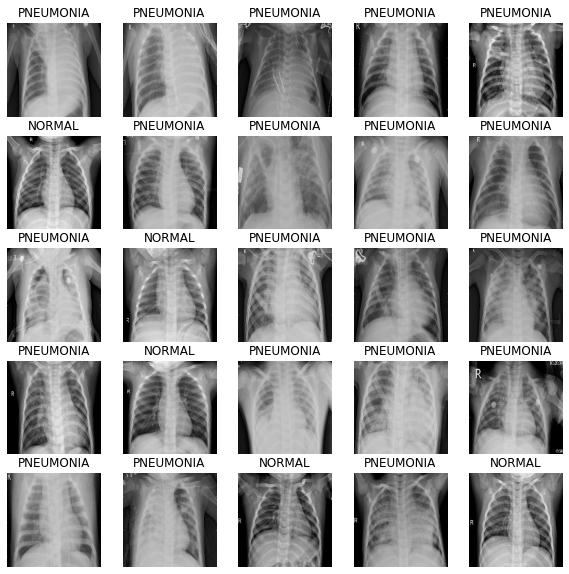

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

### 4. Build the CNN

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

The following method will define the function to build our model for us. The Dropout layers are important as they "drop out," hence the name, certain nodes to reduce the likelikhood of the model overfitting. We want to end the model with a Dense layer of one node, as this will be the output that determines if an X-ray shows an image of pneumonia.

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### 5. Correct for data imbalance

We saw earlier in this notebook that the data was imbalanced, with more images classified as pneumonia than normal. We will correct for that in this following section.

In [ ]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.06731528])

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


The weight for class `0` (Normal) is a lot higher than the weight for class `1` (Pneumonia). Because there are less normal images, each normal image will be weighted more to balance the data as the CNN works best when the training data is balanced.

#### 6. Train the model

In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
32/32 [==============================] - 150s 5s/step - recall: 0.6344 - precision: 0.9393 - accuracy: 0.6975 - loss: 0.5425 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.2666 - val_loss: 0.7107
Epoch 2/25
32/32 [==============================] - 2s 63ms/step - recall: 0.7970 - precision: 0.9678 - accuracy: 0.8286 - loss: 0.3523 - val_recall: 1.0000 - val_precision: 0.7334 - val_accuracy: 0.7334 - val_loss: 0.6377
Epoch 3/25
32/32 [==============================] - 2s 62ms/step - recall: 0.8680 - precision: 0.9781 - accuracy: 0.8877 - loss: 0.2539 - val_recall: 1.0000 - val_precision: 0.7402 - val_accuracy: 0.7402 - val_loss: 0.5762
Epoch 4/25
32/32 [==============================] - 2s 63ms/step - recall: 0.8971 - precision: 0.9821 - accuracy: 0.9109 - loss: 0.2091 - val_recall: 1.0000 - val_precision: 0.7354 - val_accuracy: 0.7354 - val_loss: 0.5942
Epoch 5/25
32/32 [==============================] - 2s 63ms/step - recall: 0.9121 - precision: 0.977

#### 7. Finetune the model

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100
32/32 [==============================] - 3s 96ms/step - recall: 0.8716 - precision: 0.9634 - accuracy: 0.8796 - loss: 0.2885 - val_recall: 1.0000 - val_precision: 0.7344 - val_accuracy: 0.7344 - val_loss: 377094.5000 - lr: 0.0100
Epoch 2/100
32/32 [==============================] - 3s 91ms/step - recall: 0.9020 - precision: 0.9706 - accuracy: 0.9070 - loss: 0.2328 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.2686 - val_loss: 331.3871 - lr: 0.0089
Epoch 3/100
32/32 [==============================] - 3s 95ms/step - recall: 0.9004 - precision: 0.9748 - accuracy: 0.9084 - loss: 0.2223 - val_recall: 0.0013 - val_precision: 1.0000 - val_accuracy: 0.2656 - val_loss: 86.2736 - lr: 0.0079
Epoch 4/100
32/32 [==============================] - 3s 91ms/step - recall: 0.9192 - precision: 0.9790 - accuracy: 0.9253 - loss: 0.1816 - val_recall: 0.3520 - val_precision: 1.0000 - val_accuracy: 0.5254 - val_loss: 5.1210 - lr: 0.0071
Epoch 5/100
32/32 [=================

#### 8. Visualizing model performance


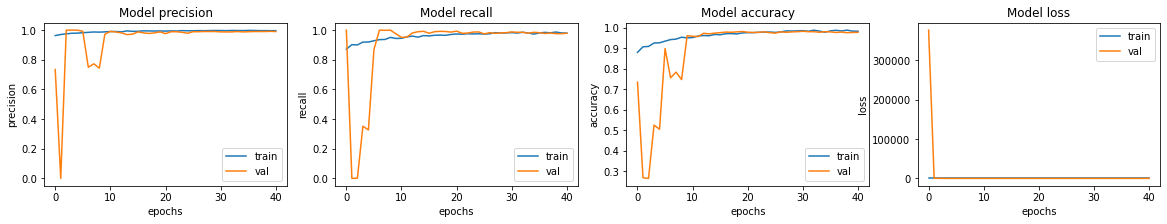

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

We see that the accuracy for our model is around 98%. Finetune the model further to see if we can achieve a higher accuracy.

#### 9. Predict and evaluate results

Let's evaluate the model on our test data!

In [ ]:
loss, acc, prec, rec = model.evaluate(test_ds)

5/5 [==============================] - 24s 5s/step - recall: 0.9974 - precision: 0.7466 - accuracy: 0.7869 - loss: 1.0298
